# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
from tqdm import tqdm, trange
import numpy as np
import torchvision
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
# Transformation for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.3081], std=[0.1306])
])

# MNIST Datasets (Images and Labels)
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Restricting the dataset to the first 128 samples
subset_indices = list(range(128))  # Indices for the first 128 samples
train_dataset_subset = Subset(train_dataset, subset_indices)

# Generating random labels
# Bernoulli distribution can be simulated using a binomial distribution with n=1
random_labels = torch.randint(0, 2, (128,))  # Generate 128 random 0s or 1s
train_dataset_subset.dataset.targets[:128] = random_labels  # Replace the first 128 labels

# Dataset Loaders (Input Pipeline)
batch_size = 128  # Make sure to set your batch size to 128
train_loader = DataLoader(dataset=train_dataset_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 30807708.53it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28855572.61it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8934602.23it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
for images, _ in train_loader:  # Original labels are not needed
    random_labels = torch.bernoulli(0.5 * torch.ones(len(images)))  # Generate random labels
    # Proceed to use these random_labels as your targets in training
# Generating random labels for the test dataset
test_random_labels = torch.bernoulli(0.5 * torch.ones(len(test_dataset)))  # Adjust the size if different


In [4]:

class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(28*28, 512)  # 28*28 is the size of MNIST images, 512 is arbitrary
        self.fc2 = nn.Linear(512, 128)    # Another layer, can be adjusted
        self.fc3 = nn.Linear(128, 2)      # Output layer: 2 units for 2 classes

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
# Initialize the model
model = FullyConnectedNet()

# If you have a GPU available and want to use it, move the model to GPU
if torch.cuda.is_available():
    model = model.cuda()


In [6]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (we use Adam here, but you can change to SGD or others)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

FullyConnectedNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [8]:
num_epochs = 60
# Initialize lists to keep track of the training and testing metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
# Modified Training Loop with Test Evaluation
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Switch to evaluation mode for testing
    model.eval() 
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for i, (images, _) in enumerate(test_loader):  # Original labels are ignored
            if torch.cuda.is_available():
                images = images.cuda()
            outputs = model(images)

            # Generating and using the random labels for the test dataset
            random_labels = test_random_labels[i * batch_size: (i+1) * batch_size]
            if torch.cuda.is_available():
                random_labels = random_labels.cuda()
            random_labels = random_labels.to(dtype=torch.long)  # Ensure correct data type for comparison

            loss = criterion(outputs, random_labels)  # Compute the loss based on random labels
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += random_labels.size(0)
            correct += (predicted == random_labels).sum().item()

        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(100 * correct / total)

    # Print the metrics for the current epoch
    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}%')


Epoch 1: Train Loss: 0.7093425989151001, Test Loss: 1.4763981118986877, Test Accuracy: 50.52%
Epoch 2: Train Loss: 1.2849161624908447, Test Loss: 0.7602776402159582, Test Accuracy: 50.63%
Epoch 3: Train Loss: 0.6275054812431335, Test Loss: 0.7554059534133235, Test Accuracy: 49.76%
Epoch 4: Train Loss: 0.7072540521621704, Test Loss: 0.736461778230305, Test Accuracy: 49.73%
Epoch 5: Train Loss: 0.6753084659576416, Test Loss: 0.7003676242466215, Test Accuracy: 50.44%
Epoch 6: Train Loss: 0.6171572208404541, Test Loss: 0.7094038408013839, Test Accuracy: 50.78%
Epoch 7: Train Loss: 0.6022339463233948, Test Loss: 0.7270557382438756, Test Accuracy: 50.44%
Epoch 8: Train Loss: 0.5916330814361572, Test Loss: 0.7286203971391991, Test Accuracy: 50.83%
Epoch 9: Train Loss: 0.5653254985809326, Test Loss: 0.7294050953056239, Test Accuracy: 50.99%
Epoch 10: Train Loss: 0.5359562635421753, Test Loss: 0.7499208057983012, Test Accuracy: 50.45%
Epoch 11: Train Loss: 0.5180232524871826, Test Loss: 0.77106

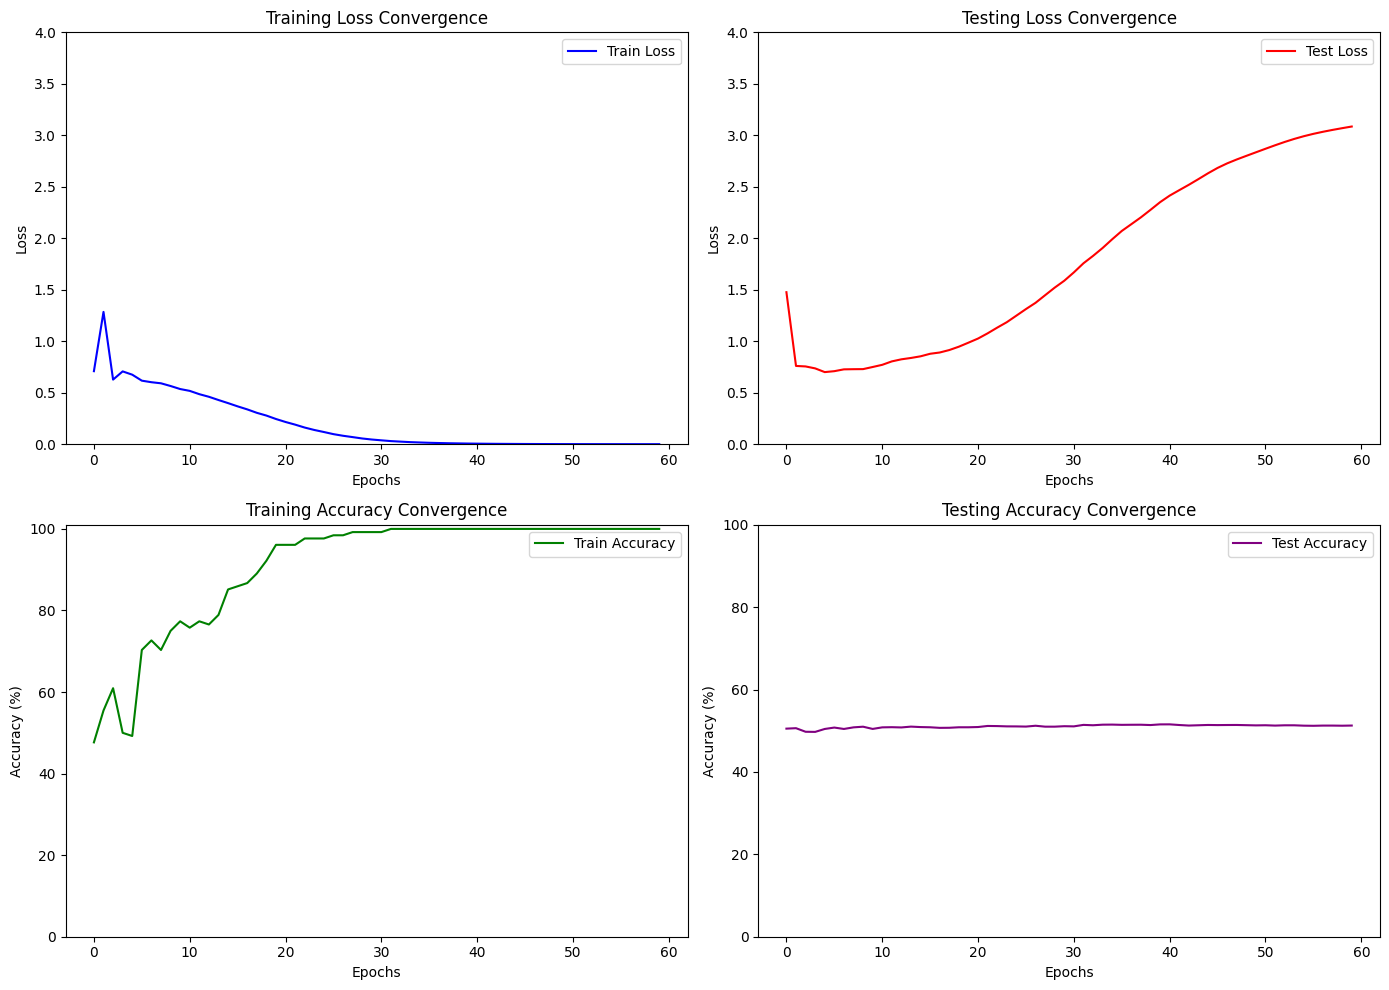

In [25]:
import matplotlib.pyplot as plt

# Setting up the figure and axes for a 2x2 grid of plots
plt.figure(figsize=(14, 10))  # Wider figure for clearer subplots

# Plotting Train Loss
plt.subplot(2, 2, 1)  # (2, 2, 1) means 2 rows, 2 columns, position 1
plt.plot(train_losses, label='Train Loss', color='blue')
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 4)  # Limiting y-axis for better visualization
plt.legend()

# Plotting Test Loss
plt.subplot(2, 2, 2)  # (2, 2, 2) means 2 rows, 2 columns, position 2
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Testing Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 4)  # Limiting y-axis for better visualization
plt.legend()

# Plotting Train Accuracy
plt.subplot(2, 2, 3)  # (2, 2, 3) means 2 rows, 2 columns, position 3
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.title('Training Accuracy Convergence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 101)  # Limiting y-axis for better visualization
plt.legend()

# Plotting Test Accuracy
plt.subplot(2, 2, 4)  # (2, 2, 4) means 2 rows, 2 columns, position 4
plt.plot(test_accuracies, label='Test Accuracy', color='purple')
plt.title('Testing Accuracy Convergence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Limiting y-axis for better visualization
plt.legend()

# Display the plots
plt.tight_layout()  # Adjusts subplot params for better spacing
plt.show()


# Analysis of Overfitting with Random Labels

The provided plots illustrate key concepts related to overfitting, particularly when training a model on data with randomly assigned binary labels. Below is a breakdown of each plot and its implications.

## Training Loss Convergence



The **Training Loss Convergence** plot shows a steady decrease in loss over epochs, approaching a value close to zero. This indicates the Fully Connected network's effective learning from the training data. However, given the random label assignments, this "learning" is essentially the network memorizing arbitrary associations between input images and their labels, rather than discerning any meaningful, generalizable patterns.

## Testing Loss Convergence



Conversely, the **Testing Loss Convergence** plot displays an increasing trend in loss over epochs, a classic indicator of overfitting. The model, increasingly proficient at predicting the training set's random labels, fails to effectively generalize this "knowledge" to the test set. This increasing loss reflects the model's predictions for the unseen test data being no better than random guessing.

## Training Accuracy Convergence



The **Training Accuracy** plot demonstrates that the model achieves near-perfect accuracy on the training data, expected as the model memorizes the training set, including its random labels. However, this accuracy is misleading as it does not reflect the model's ability to generalize to new data.

## Testing Accuracy Convergence



The **Testing Accuracy** plot shows fluctuations around the 50% mark, indicative of random guessing. This performance aligns with expectations for a model evaluated on data with randomly assigned binary labels. The accuracy's consistency around 50% underscores the model's inability to learn meaningful patterns from the training data applicable to the test data.

## Explanation and Conclusion

These results present a clear case of overfitting, where a model trained on data with random labels exhibits impressive performance on this training data but fails to generalize to new, unseen data. The stark contrast between near-zero training loss and high training accuracy versus increasing test loss and test accuracy hovering around random chance (50%) highlights the critical importance of meaningful data. This experiment underscores the potential pitfalls of overfitting, especially in scenarios where the data lacks inherent patterns or the labels do not accurately reflect the data's true nature.


********************

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks.
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example.
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

Getting glove embeddings

Necessary folders creation

In [10]:
import os

# Define the folders
folders_to_create = ['output_files', 'save_data', 'save_data/acc', 'save_data/loss', 'save_data/pkl']

# Check if each folder exists, and create it if it doesn't
for folder in folders_to_create:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Created folder: output_files
Created folder: save_data
Created folder: save_data/acc
Created folder: save_data/loss
Created folder: save_data/pkl


first view of the data

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('trainEmotions.csv')
test_df = pd.read_csv('testEmotions.csv')

# Inspect the first few rows of the training data
print(train_df.head())
print()
# Check the distribution of labels
print(train_df['emotion'].value_counts())
print()
# Check for missing values
print(train_df.isnull().sum())

     emotion                                            content
0  happiness  victory for the bulldogs was celebrated by 3 w...
1  happiness                     @saraLDS Thanks for that, Sara
2  happiness  @Tony_Mandarich well welcome back from the dar...
3  happiness            @sai_shediddy lol , you gotta share too
4  happiness  first up, make up for lost time with jelly. Ja...

emotion
happiness    5430
neutral      5182
sadness      3892
Name: count, dtype: int64

emotion    0
content    0
dtype: int64


finding mean and max tweet lengths

In [12]:
import numpy as np

max_len = np.max(train_df['content'].apply(lambda x: len(x)))
mean_len = np.mean(train_df['content'].apply(lambda x: len(x)))
print(max_len)
print(mean_len)

161
70.78254274682845


Cleaning of the tweets

In [13]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle
import re
import os
from gensim import downloader

# Constants
GLOVE_PATH = "glove-twitter-100"
PICKLE_PATH = "glove_embeddings.pkl"


# Load or create embeddings
def load_or_create_embeddings(glove_path, pickle_path):
    try:
        if os.path.exists(pickle_path):
            with open(pickle_path, "rb") as file:
                embeddings = pickle.load(file)
            print("Embeddings loaded from pickle.")
        else:
            print(
                "Embeddings pickle not found. Loading from GloVe. (this may take a few minutes)"
            )
            embeddings = downloader.load(glove_path)
            with open(pickle_path, "wb") as file:
                pickle.dump(embeddings, file)
            print("Embeddings loaded from GloVe and saved to pickle.")
        return embeddings
    except Exception as e:
        print("Error loading embeddings:", e)
        return None


def create_weights(target_vocab):
    glove = load_or_create_embeddings(GLOVE_PATH, PICKLE_PATH)
    matrix_len = len(target_vocab) + 1
    weights_matrix = np.zeros((matrix_len, 100))
    words_found = 0
    for i, word in enumerate(target_vocab):
        if type(word) != str:
            continue
        try:
            lower_word = word.lower()
            weights_matrix[i + 1] = glove[lower_word] if lower_word in glove.index_to_key else glove["<unknown>"]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(100,))
        except Exception as e:
            print(e)
    return weights_matrix



def tokenize_line(line, vocab_to_int):
    return [vocab_to_int[w] for w in line.split()]


def pad_features(tweet, seq_length=161):
    """Return features matrix 2D of tweets_int, where each tweet is padded with 0's or truncated
    to the input seq_length."""
    tweet_len = len(tweet)
    if tweet_len <= seq_length:
        zeroes = list(np.zeros(seq_length - tweet_len))
        new = zeroes + tweet  ## zeroes in the begining
    else:
        new = tweet[0:seq_length]
    return np.array(new)


def create_vocabulary(all_text):
    all_text2 = " ".join(all_text)
    # create a list of words
    words = all_text2.split()
    # Count all the words using Counter Method
    count_words = Counter(words)
    total_words = len(words)
    sorted_words = count_words.most_common(total_words)

    ##  later on we are going to do padding for shorter reviews and conventional choice for padding is 0.
    # So we need to start this indexing from 1
    vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}
    int_to_vocab = {str(value): key for key, value in vocab_to_int.items()}
    return vocab_to_int, int_to_vocab


def sub(pattern, output, string, whole_word=False):
    token = output
    if whole_word:
        pattern = r"(\s|^)" + pattern + r"(\s|$)"

    if isinstance(output, str):
        token = " " + output + " "
    else:
        token = lambda match: " " + output(match) + " "
    return re.sub(pattern, token, string)


def hashtag(token):
    token = token.group("tag")
    if token != token.upper():
        token = " ".join(re.findall("[a-zA-Z][^A-Z]*", token))
    return "<hashtag> " + token + " <endhashtag>"


def punc_repeat(token):
    return token.group(0)[0] + " <repeat>"


def punc_separate(token):
    return token.group()


def number(token):
    return " <number>"


def word_end_repeat(token):
    return token.group(1) + token.group(2) + " <elong>"


def preprocess_glove_line(tweet):
    eyes = r"[8:=;]"
    nose = r"['`\-\^]?"
    sad_front = r"[(\[/\\]+"
    sad_back = r"[)\]/\\]+"
    smile_front = r"[)\]]+"
    smile_back = r"[(\[]+"
    lol_front = r"[DbpP]+"
    lol_back = r"[d]+"
    neutral = r"[|]+"
    sadface = eyes + nose + sad_front + "|" + sad_back + nose + eyes
    smile = eyes + nose + smile_front + "|" + smile_back + nose + eyes
    lolface = eyes + nose + lol_front + "|" + lol_back + nose + eyes
    neutralface = eyes + nose + neutral + "|" + neutral + nose + eyes
    punctuation = r"""[ '!"#$%&'()+,/:;=?@_`{|}~\*\-\.\^\\\[\]]+"""  ## < and > omitted to avoid messing up tokens

    tweet = sub(r"[\s]+", "  ", tweet)  # ensure 2 spaces between everything
    tweet = sub(r"(?:(?:https?|ftp)://|www\.)[^\s]+", "<url>", tweet, True)
    tweet = sub(r"@\w+", "<user>", tweet, True)
    tweet = sub(r"#(?P<tag>\w+)", hashtag, tweet, True)
    tweet = sub(sadface, "<sadface>", tweet, True)
    tweet = sub(smile, "<smile>", tweet, True)
    tweet = sub(lolface, "<lolface>", tweet, True)
    tweet = sub(neutralface, "<neutralface>", tweet, True)
    tweet = sub(r"(?:<3+)+", "<heart>", tweet, True)
    tweet = tweet.lower()
    tweet = sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", number, tweet, True)
    tweet = sub(punctuation, punc_separate, tweet)
    tweet = sub(r"([!?.])\1+", punc_repeat, tweet)
    tweet = sub(r"(\S*?)(\w)\2+\b", word_end_repeat, tweet)
    tweet = tweet.split()
    return " ".join(tweet)


def encoder(label):
    if label == "happiness":
        return 0
    elif label == "neutral":
        return 1
    return 2


def preprocess_labels(labels):
    data_labels = labels.apply(lambda x: encoder(x))
    return np.array(data_labels)


def run_preprocessing():
    train = pd.read_csv("trainEmotions.csv")
    test = pd.read_csv("testEmotions.csv")

    train["clean_tweet"] = np.zeros(train.shape[0])
    for i, tweet in enumerate(train.content.values):
        clean_tweet = preprocess_glove_line(tweet)
        train.iloc[i, 2] = clean_tweet

    train.to_csv("output_files/train_glove")
    ## create vocabulary from train
    vocab_to_int, int_to_vocab = create_vocabulary(all_text=train["clean_tweet"].values)
    pd.DataFrame.from_dict(vocab_to_int, orient="index").to_csv(
        "output_files/vocab_to_int.csv", index=True, header=True
    )

    vocab_words = vocab_to_int.keys()
    max_tweet = train.loc[
        train[["clean_tweet"]].apply(lambda x: x.str.len(), axis=1).idxmax()
    ]
    max_tweet_len = max_tweet["clean_tweet"].str.len().values[0]
    ##apply final preprcoesing on train
    final_train = []
    for i, clean_tweet in enumerate(train.clean_tweet.values):
        token_tweet = tokenize_line(clean_tweet, vocab_to_int)
        final_tweet = pad_features(token_tweet, seq_length=max_tweet_len)
        final_train.append(final_tweet)

    final = np.array(final_train)
    np.save("output_files/train_data", final)
    train_labels = preprocess_labels(train.emotion)
    np.save("output_files/train_labels", train_labels)

    ## apply preprocessing on test
    test["clean_tweet"] = np.zeros(test.shape[0])
    final_test = []
    for i, tweet in enumerate(test.content.values):
        clean_tweet = preprocess_glove_line(tweet)
        clean_tweet_filter = [c for c in clean_tweet.split() if c in vocab_words]
        clean_tweet_filter = " ".join(clean_tweet_filter)
        test.iloc[i, 2] = clean_tweet_filter
        token_tweet = tokenize_line(clean_tweet_filter, vocab_to_int)
        final_tweet = pad_features(token_tweet, seq_length=max_tweet_len)
        final_test.append(final_tweet)

    final = np.array(final_test)
    np.save("output_files/test_data", final)
    test.to_csv("output_files/test_glove")
    test_labels = preprocess_labels(test.emotion)
    np.save("output_files/test_labels", test_labels)
    return train, test


# preprocess_glove_embs()
train_df, test_df = run_preprocessing()
vocab = pd.read_csv("output_files/vocab_to_int.csv")
# glove = pd.read_csv("glove.csv", header=None)
target_vocab = vocab.iloc[:, 0].values
weights_matrix = create_weights(target_vocab)
np.save("output_files/weight_mat.npy", weights_matrix)


C:\Users\ziv zakalik\AppData\Local\Temp\ipykernel_30876\3036848016.py:176: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'victory for the bulldogs was celebrated by <number> white chocolate cheesecakes nom nom nom whatta fatty <elong>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train.iloc[i, 2] = clean_tweet
C:\Users\ziv zakalik\AppData\Local\Temp\ipykernel_30876\3036848016.py:209: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<user> very heart - warming indeed . i ' l <elong> be looking forward to that day' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test.iloc[i, 2] = clean_tweet_filter


Embeddings pickle not found. Loading from GloVe. (this may take a few minutes)
Embeddings loaded from GloVe and saved to pickle.


### Some statistics to better undertand the data

We can see that our labels are fairly balanced. This is very important and makes our job easier.

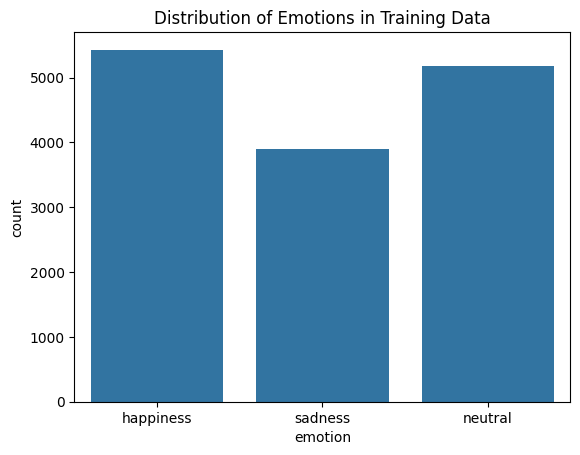

In [14]:
sns.countplot(x='emotion', data=train_df)
plt.title('Distribution of Emotions in Training Data')
plt.show()

*****************************

Tweet lengths vary, but not by much. We will need to keep an eye on that while working on our models.

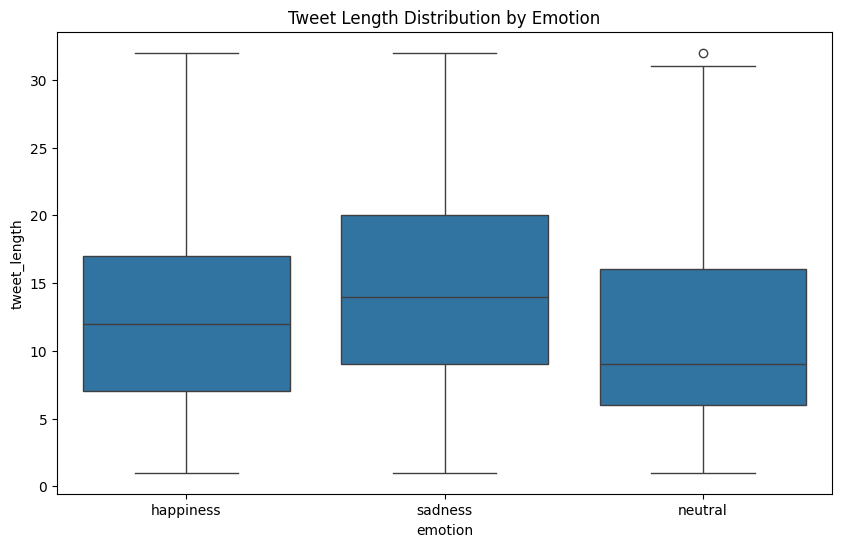

In [15]:
train_df['tweet_length'] = train_df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='tweet_length', data=train_df)
plt.title('Tweet Length Distribution by Emotion')
plt.show()


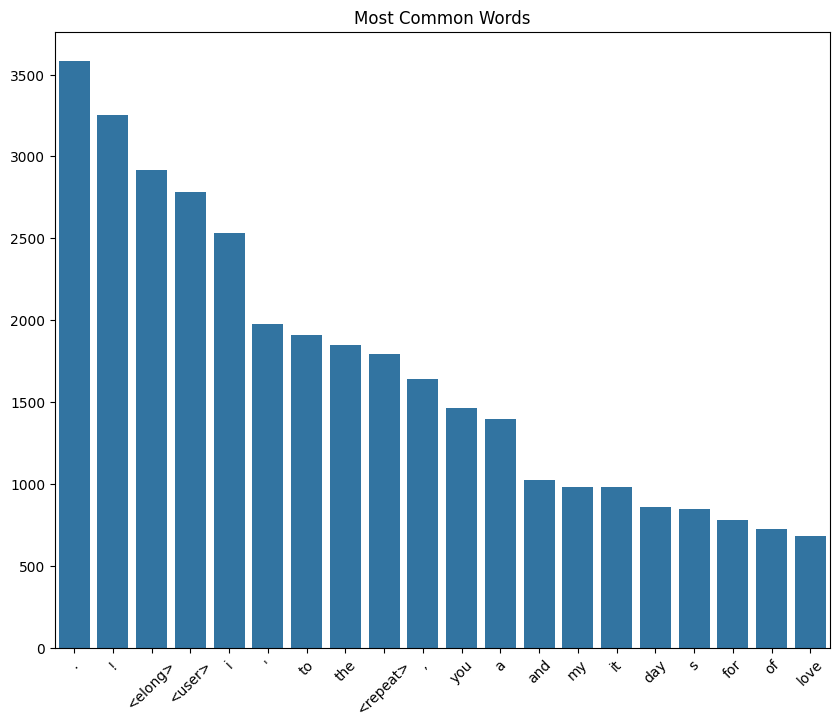

In [16]:
from collections import Counter

def plot_most_common_words(text, n_most_common=20):
    words = ' '.join(text).split()
    counter = Counter(words)
    most_common = counter.most_common(n_most_common)
    words, counts = zip(*most_common)

    plt.figure(figsize=(10, 8))
    sns.barplot(y=list(counts), x=list(words))
    plt.title('Most Common Words')
    plt.xticks(rotation=45)
    plt.show()

# Example for happiness tweets
happy_texts = train_df[train_df['emotion'] == 'happiness']['clean_tweet']
plot_most_common_words(happy_texts)


### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

# Pre-processing the data

# Defining both models

# Training

Defining our models

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def create_embedding_layer(weights_matrix):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({"weight": weights_matrix})
    return emb_layer, num_embeddings, embedding_dim


class SentimentLSTM(nn.Module):
    def __init__(
        self, weights_matrix, output_size, hidden_dim, n_layers, drop_prob=0.5
    ):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding, num_embeddings, embedding_dim = create_embedding_layer(
            weights_matrix
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out[:, -1]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return self.log_softmax(out), hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden_state = weight.new_zeros(self.n_layers * 2, batch_size, self.hidden_dim)
        return (
            (hidden_state, hidden_state)
            if torch.cuda.is_available()
            else (hidden_state.cpu(), hidden_state.cpu())
        )


class SentimentRNN(nn.Module):
    def __init__(
        self, weights_matrix, output_size, hidden_dim, n_layers, drop_prob=0.5
    ):
        super(SentimentRNN, self).__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding, num_embeddings, embedding_dim = create_embedding_layer(
            weights_matrix
        )
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(drop_prob)
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        embeds = self.embedding(x)
        h0 = self.init_hidden(x.size(0))
        rnn_out, hn = self.rnn(embeds)
        rnn_out = rnn_out[:, -1, :]
        out = self.dropout(rnn_out)
        out = self.fc(rnn_out)
        return self.log_softmax(out), h0

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden_state = weight.new_zeros(self.n_layers, batch_size, self.hidden_dim)
        return (
            (hidden_state, hidden_state)
            if torch.cuda.is_available()
            else (hidden_state.cpu(), hidden_state.cpu())
        )




Main code - training, evaluating

main.py

In [18]:
import random
import numpy as np
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import pandas as pd
from torch import nn
import os
from torch.utils.data import DataLoader, TensorDataset
import itertools
import time
import copy

# create Tensor datasets
train_data, train_labels = np.load("output_files/train_data.npy"), np.load(
    "output_files/train_labels.npy"
)
test_data, test_labels = np.load("output_files/test_data.npy"), np.load(
    "output_files/test_labels.npy"
)
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))


def train_model(
    model,
    device,
    batch_size,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=50,
):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    trigger_times = 0
    loss_dict = {"train": [], "test": []}
    acc_dict = {"train": [], "test": []}
    patience = int(num_epochs // 6) + 1
    best_acc = 0
    predictions = {"train": [], "test": []}
    best_predictions = {}
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            predicted_list = []
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            correct = 0
            total = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if len(labels) != batch_size:
                    continue
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # h = tuple([each.data for each in h])
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # forward
                    outputs, h = model(inputs.long())
                    _, preds = torch.max(outputs, 1, keepdim=True)  # check the labels
                    loss = criterion(outputs.squeeze(), labels.long())  # compute loss
                    predicted_list.append(preds)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()  # backward
                        nn.utils.clip_grad_norm_(model.parameters(), 5)
                        optimizer.step()  # Optimization step - update weights

                # statistics
                running_loss += loss.item() * inputs.size(0)
                correct += (preds == labels.reshape(-1, 1)).sum()
                total += labels.size(0)

            if phase == "train":
                scheduler.step()

            predictions[phase] = copy.deepcopy(predicted_list)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(correct) / total

            print(
                "{} Loss: {:.4f} Accuracy: {:.4f} ".format(phase, epoch_loss, epoch_acc)
            )

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            # early stopping
            if phase == "test":
                if epoch_acc > best_acc:
                    trigger_times = 0
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_predictions = copy.deepcopy(predictions)
                else:
                    if epoch > 5:
                        trigger_times += 1
                        print("Trigger Times:", trigger_times)

                if trigger_times >= patience:
                    model.load_state_dict(best_model_wts)

                    print("Early stopping!")
                    return model, loss_dict, acc_dict, best_acc, best_predictions
    print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict, best_acc, best_predictions


def runner(model, lr=0.01, batch_size=32, num_epochs=20):
    # Load datasets
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    dataloaders = {"train": train_loader, "test": test_loader}
    dataset_sizes = {"train": len(train_data), "test": len(test_data)}

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return train_model(
        model,
        device,
        batch_size,
        dataloaders,
        dataset_sizes,
        criterion,
        optimizer,
        scheduler,
        num_epochs,
    )


## hyperparameter optimization
HPO = {
    "batch_size": [32],
    "lr": [0.005],
    "epochs": [30],
    "n_layers": [1, 3],
    "n_hidden_units": [32],
    "drop_prob": [0.3, 0.5],
    "n_emb": [100],
}

# create permutations of all possible hyperparameters
All_params = list(itertools.product(*(HPO[param] for param in HPO.keys())))
random.shuffle(All_params)
output_size = 3
path = "save_data"

# Simple LSTM glove loop
best_model = None
best_model_acc = 0
best_model_csv_paths = {}
for model_class in [SentimentRNN, SentimentLSTM]:
    for i in range(len(All_params)):
        curr_params = All_params[i]
        batch_size, lr, epochs, n_layers, n_hidden, drop_prob = (
            curr_params[0],
            curr_params[1],
            curr_params[2],
            curr_params[3],
            curr_params[4],
            curr_params[5],
        )
        curr_params = f"model={model_class.__name__}_lr={lr}_b={batch_size}_t={epochs}_n_layers={n_layers}_n_hid={n_hidden}_p={drop_prob}"
        print("Starting parameters:")
        print(curr_params)
        weights_puncs = np.load("output_files/weight_mat.npy")
        weights_puncs = torch.from_numpy(weights_puncs)
        model = model_class(weights_puncs, output_size, n_hidden, n_layers, drop_prob)
        trained_model, loss_dict, acc_dict, best_acc, best_predictions = runner(
            model, lr, batch_size, epochs
        )
        results = f"_best_acc={round(best_acc, 4)}"
        file_name = curr_params + results
        torch.save(
            trained_model.state_dict(), os.path.join(path, "pkl/" + file_name + ".pkl")
        )
        if best_model_acc < best_acc:
            best_model_acc = best_acc
            best_model = trained_model
            best_model_csv_paths = {
                "loss": os.path.join(path, "loss/" + file_name),
                "acc": os.path.join(path, "acc/" + file_name),
            }
        loss_df = pd.DataFrame(loss_dict)
        acc_df = pd.DataFrame(acc_dict)
        loss_df.to_csv(os.path.join(path, "loss/" + file_name))
        acc_df.to_csv(os.path.join(path, "acc/" + file_name))

print("Best model accuracy:", best_model_acc)

Starting parameters:
model=SentimentRNN_lr=0.005_b=32_t=30_n_layers=1_n_hid=32_p=0.3
Epoch 0/29
----------
train Loss: 0.9162 Accuracy: 0.5705 
test Loss: 1.1276 Accuracy: 0.4785 
Epoch 1/29
----------
train Loss: 0.7079 Accuracy: 0.7077 
test Loss: 1.3036 Accuracy: 0.5091 
Epoch 2/29
----------
train Loss: 0.5464 Accuracy: 0.7879 
test Loss: 1.1645 Accuracy: 0.5203 
Epoch 3/29
----------
train Loss: 0.4168 Accuracy: 0.8386 
test Loss: 1.5809 Accuracy: 0.4911 
Epoch 4/29
----------
train Loss: 0.3357 Accuracy: 0.8716 
test Loss: 1.7137 Accuracy: 0.4849 
Epoch 5/29
----------
train Loss: 0.2738 Accuracy: 0.8937 
test Loss: 1.8105 Accuracy: 0.4870 
Epoch 6/29
----------
train Loss: 0.2481 Accuracy: 0.9047 
test Loss: 2.1708 Accuracy: 0.4714 
Trigger Times: 1
Epoch 7/29
----------
train Loss: 0.1749 Accuracy: 0.9321 
test Loss: 2.4297 Accuracy: 0.4704 
Trigger Times: 2
Epoch 8/29
----------
train Loss: 0.1550 Accuracy: 0.9407 
test Loss: 2.5179 Accuracy: 0.4756 
Trigger Times: 3
Epoch 9/2

d:\anaconda\envs\ml2hw2\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


train Loss: 0.8244 Accuracy: 0.6357 
test Loss: 0.9676 Accuracy: 0.5664 
Epoch 1/29
----------
train Loss: 0.5956 Accuracy: 0.7592 
test Loss: 1.2466 Accuracy: 0.5017 
Epoch 2/29
----------
train Loss: 0.3819 Accuracy: 0.8565 
test Loss: 1.5931 Accuracy: 0.4990 
Epoch 3/29
----------
train Loss: 0.2505 Accuracy: 0.9049 
test Loss: 1.7756 Accuracy: 0.5081 
Epoch 4/29
----------
train Loss: 0.1873 Accuracy: 0.9305 
test Loss: 2.0521 Accuracy: 0.5064 
Epoch 5/29
----------
train Loss: 0.1537 Accuracy: 0.9418 
test Loss: 2.3492 Accuracy: 0.4696 
Epoch 6/29
----------
train Loss: 0.1219 Accuracy: 0.9512 
test Loss: 2.9665 Accuracy: 0.4779 
Trigger Times: 1
Epoch 7/29
----------
train Loss: 0.0880 Accuracy: 0.9657 
test Loss: 3.0411 Accuracy: 0.4795 
Trigger Times: 2
Epoch 8/29
----------
train Loss: 0.0754 Accuracy: 0.9710 
test Loss: 3.1495 Accuracy: 0.4808 
Trigger Times: 3
Epoch 9/29
----------
train Loss: 0.0680 Accuracy: 0.9730 
test Loss: 3.3714 Accuracy: 0.4770 
Trigger Times: 4
Epoc

d:\anaconda\envs\ml2hw2\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


train Loss: 0.8572 Accuracy: 0.6140 
test Loss: 1.1174 Accuracy: 0.5120 
Epoch 1/29
----------
train Loss: 0.6268 Accuracy: 0.7497 
test Loss: 1.1536 Accuracy: 0.5321 
Epoch 2/29
----------
train Loss: 0.4284 Accuracy: 0.8383 
test Loss: 1.3139 Accuracy: 0.5207 
Epoch 3/29
----------
train Loss: 0.2860 Accuracy: 0.8933 
test Loss: 1.5830 Accuracy: 0.5238 
Epoch 4/29
----------
train Loss: 0.2218 Accuracy: 0.9193 
test Loss: 2.1153 Accuracy: 0.4789 
Epoch 5/29
----------
train Loss: 0.1741 Accuracy: 0.9341 
test Loss: 2.3404 Accuracy: 0.4905 
Epoch 6/29
----------
train Loss: 0.1577 Accuracy: 0.9385 
test Loss: 2.4600 Accuracy: 0.5025 
Trigger Times: 1
Epoch 7/29
----------
train Loss: 0.1095 Accuracy: 0.9580 
test Loss: 2.7401 Accuracy: 0.4988 
Trigger Times: 2
Epoch 8/29
----------
train Loss: 0.0995 Accuracy: 0.9619 
test Loss: 2.9764 Accuracy: 0.4925 
Trigger Times: 3
Epoch 9/29
----------
train Loss: 0.0926 Accuracy: 0.9638 
test Loss: 3.0952 Accuracy: 0.4921 
Trigger Times: 4
Epoc

Plotting graphs

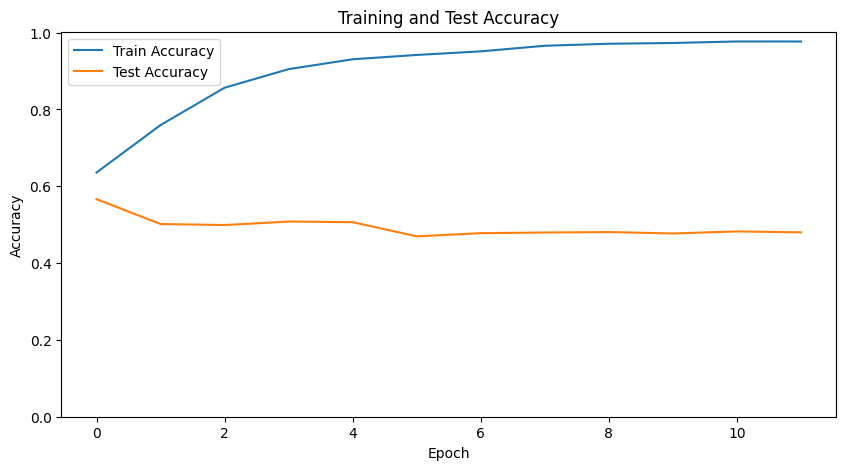

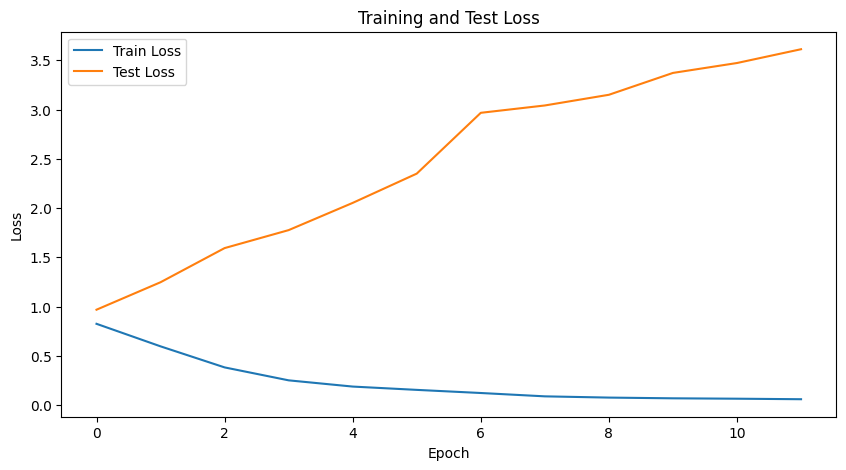

In [19]:
# Read the CSV data into pandas DataFrames
acc_df = pd.read_csv(best_model_csv_paths['acc'], index_col=0)
loss_df = pd.read_csv(best_model_csv_paths['loss'], index_col=0)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_df['train'], label='Train Accuracy')
plt.plot(acc_df['test'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_df['train'], label='Train Loss')
plt.plot(loss_df['test'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Inference for conf matrix

In [20]:
import argparse
import pandas as pd
import torch
from collections import OrderedDict
import numpy as np
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_tweet_len = 263

model.eval()

vocab_to_int = pd.read_csv('output_files/vocab_to_int.csv')
vocab_words = vocab_to_int.iloc[:, 0].values
vocab_to_int = {key: value for key, value in zip(vocab_words, vocab_to_int.iloc[:, 1])}

def decoder(label):
    if label == 0:
        return 'happiness'
    elif label == 1:
        return 'neutral'
    return 'sadness'

def infer_emotion(tweet):
    input_transformed = run_preprocessing(tweet, max_tweet_len).long().unsqueeze(0).to(device)
    output, _ = best_model(input_transformed.long())  # forward
    _, pred = torch.max(output, 1, keepdim=True)  # check the labels
    return decoder(int(pred)) # decode the emotion back to str


def run_preprocessing(tweet, max_tweet_len):
    clean_tweet = preprocess_glove_line(tweet)
    clean_tweet_filter = [c for c in clean_tweet.split() if c in vocab_words]
    clean_tweet_filter = ' '.join(clean_tweet_filter)
    token_tweet = tokenize_line(clean_tweet_filter, vocab_to_int)
    final_tweet = pad_features(token_tweet, seq_length=max_tweet_len)
    return torch.Tensor(final_tweet)

test_data = pd.read_csv("testEmotions.csv")
test_data['inferred_emotion'] = test_data['content'].apply(lambda x: infer_emotion(x))
train_data = pd.read_csv("trainEmotions.csv")
train_data['inferred_emotion'] = train_data['content'].apply(lambda x: infer_emotion(x))




In [21]:
## Confusion Matrix calculation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_mat(y_lab, preds, Data):
    ##plot results
    cm = confusion_matrix(y_lab, preds)
    fig = plt. figure()
    ax = fig.add_subplot(111)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', ax=ax)
    # Labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'{Data} Confusion matrix')
    ax.xaxis. set_ticklabels(['Happiness', 'Neutral', 'Sadness'])
    ax.yaxis. set_ticklabels(['Happiness', 'Neutral', 'Sadness'])
    plt. show()

We can see in the confusion matrix, that our model had trouble predicting "happiness".</br>
Moreover, we see that it had a bias towards sadness, which is interesting to look further into, and might help with improving our model.

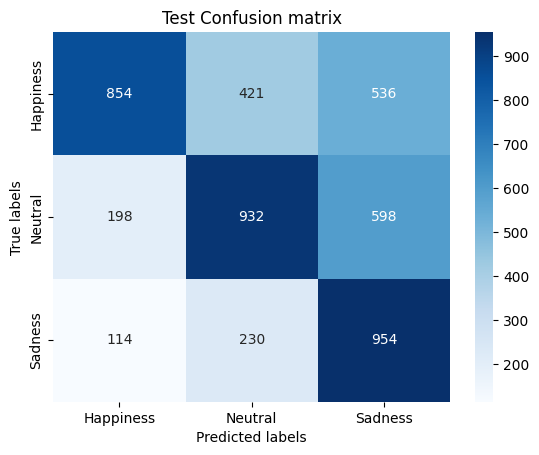

In [22]:
pred_test = test_data['inferred_emotion'].values
real_test = test_data['emotion'].values

plot_confusion_mat(real_test, pred_test,'Test')

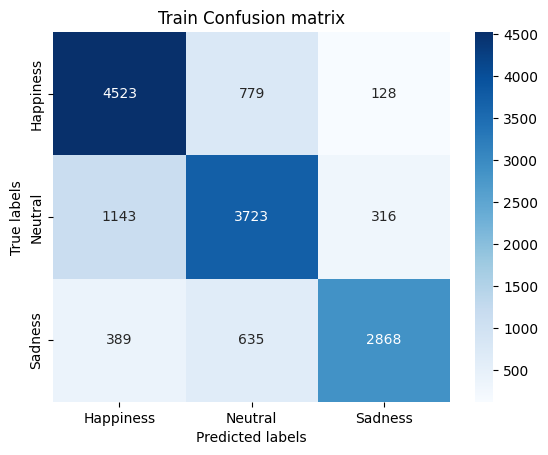

In [23]:
pred_train = train_data['inferred_emotion'].values
real_train = train_data['emotion'].values

plot_confusion_mat(real_train, pred_train, 'Train')

*****************************

### c) Discussion (10 pt)
<p style="font-size: 17px">
Discuss the differences in the methods you have tried.
</p>

*****************************

### 1. Different models
While trying both RNN and LSTM, our assumption was that LSTM would perform significantly better. While it did perform better, RNN had respectable results.

### 2. Bi VS One directional LSTM
As expected, Bi-LSTM performed better for out task, we can use context from both ends of the tweet, which might help us with our sentiment analysis.


### 3. Different parameters
We created a convenient infrastructure in order to easily try out different parameters. After some trial and error, we reached our optimal params:</br>
Batch Size: 32</br>
Learning Rate (lr): 0.005</br>
Epochs: 30</br>
Number of Layers: 3</br>
Number of Hidden Units: 32</br>
Dropout Probability: 0.5</br>
Number of Embedding Units: 100</br>
Model: Bi-LSTM

### 4. Preprocessing
A significant portion of our work was preprocessing. This has significantly increased perfomance.

### 5. Regularization and optimization
Using gradient clipping and dropout helps us deal with regularization and exploding gradients.</br>
For some optimizatin, we implemented early stopping, to speed up our testing.